# Chainerで回帰
## 必要なモジュールの読み込み

In [ ]:
# 必要ライブラリのインストール
!pip install chainer
!pip install numpy
!pip install pandas
!pip install matplotlib

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 今回は家賃のデータを利用する
df = pd.read_csv('data/housing.csv')

In [3]:
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,y
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## 入力変数と教師データに分割

In [4]:
# df.iloc[行, 列]
x = df.iloc[:, :-1].values.astype('f')  # １番後ろからひとつ手前
t = df.iloc[:, -1].values.astype('f')  # １番後ろだけ

In [5]:
x.shape

(506, 13)

In [6]:
t.shape

(506,)

回帰の場合は、ラベルを`(506, 1)`にしなければならない。ので...

In [7]:
t = t.reshape(len(t), 1)

In [8]:
t.shape

(506, 1)

In [9]:
t.dtype

dtype('float32')

実は、こんな煩わしいことしなくても、下記の１文で望んでいる形でデータを取れる

In [10]:
t = df.iloc[:, -1:].values.astype('f')  # １番後ろだけ

In [11]:
t.shape

(506, 1)

In [12]:
t.dtype

dtype('float32')

## データセットの準備
Chainerでデータセットを渡す際には、『タプル』で囲って『リスト』で囲む形式にしなければならない。

In [13]:
dataset = list(zip(x,t))

## 訓練データと検証データの分割

In [14]:
import chainer
import chainer.functions as F
import chainer.links as L

D:\Anaconda3\envs\Chainer\lib\site-packages\chainer\backends\cuda.py:98: UserWarning: cuDNN is not enabled.
Please reinstall CuPy after you install cudnn
(see https://docs-cupy.chainer.org/en/stable/install.html#install-cudnn).
  'cuDNN is not enabled.\n'


In [15]:
# 訓練データを7割にする。
n_train = int(len(dataset)*0.7)
n_train

354

In [16]:
# Chainerの分割するモジュールを利用してデータを分割
train, test = chainer.datasets.split_dataset_random(dataset=dataset, first_size=n_train, seed=0)

In [17]:
print(len(train))
print(len(test))
len(train)/len(dataset)*100

354
152


69.96047430830039

## 回帰モデルの定義
回帰のモデルを作成する方法は大きく分けて２種類あります。  
- L.Classifierを使う場合
- 学習用のモデルを自前で書く場合


### L.Classifierを使う場合
Chainerには『L.regressor』のような回帰に特化した物が用意されていない！！

In [41]:
# 13->5->1
class NN(chainer.Chain):
    # モデルの構造を明示
    def __init__(self, n_mid_units=5, n_out=1):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(None, n_mid_units)  # 入力層
            self.fc2 = L.Linear(None, n_out)  # 出力層

    # 順伝播
    def __call__(self, x):
        h = self.fc1(x)
        h = F.relu(h)
        h = self.fc2(h)
        return h

In [42]:
# インスタンス化前にシードを固定
np.random.seed(0)
# インスタンス化
nn = NN()

#### L.Classifierの設定について
分類と回帰で大きく異なる点は**損失関数**である。
- 回帰  
平均二乗誤差
- 分類  
交差エントロピー

損失関数を設定してあげる必要がある！

In [43]:
model = L.Classifier(nn, lossfun=F.mean_squared_error)  # lossfunを平均二乗誤差を設定する。

精度を計測するために、分類では、『accuracy』で精度を測ったが、  
回帰では、ピンポイントで正解することは少ないので、誤差のみを考える。  
そのため、『model.compute_accuracy』をFalseにする。

In [44]:
model.compute_accuracy = False

## 学習用のモデルを自前で書く場合
クラスの中に以下３つの要素を追加する必要がある。

- `__init__`：モデルで使用するリンクの宣言
- `__call__`：損失関数の宣言
- `predictor`：順伝播の宣言


In [45]:
# # 13->5->1
# class NN(chainer.Chain):
#     # モデルの構造を明示
#     def __init__(self, n_mid_units=5, n_out=1):
#         super().__init__()
#         with self.init_scope():
#             self.fc1 = L.Linear(None, n_mid_units)  # 入力層
#             self.fc2 = L.Linear(None, n_out)  # 出力層
    
#     # 損失関数を計算
#     def __call__(self, x, t):
#         y = self.predictor(x)  # 予測値の計算（順伝播）
#         loss = F.mean_squared_error(t, y)  # 損失関数の計算
#         chainer.report({'loss':loss}, self)  # レポート出力の設定
#         return loss  # 損失関数を返す
    
#     # 順伝播
#     def predictor(self, x):
#         h = self.fc1(x)
#         h = F.relu(x)
#         h = self.fc2(h)
#         return h

In [46]:
# # インスタンス化する
# np.random.seed(0)
# model = NN()

## 学習に必要な準備
今回は、L.Classifierを利用する。

### Optimizerの設定

In [47]:
optimizer = chainer.optimizers.SGD()  # 確率的勾配降下法

In [48]:
optimizer.setup(model)

### Iteratorの設定

In [49]:
# データに応じてサイズを決定
batchsize = 10

In [50]:
# 学習とテスト用のIteratorを設定する。
train_iter = chainer.iterators.SerialIterator(train, batchsize)
# テストの設定をする。
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)# データに応じてサイズを決定

### Updaterの設定


In [51]:
from chainer import training

In [52]:
updater = training.StandardUpdater(train_iter, optimizer, device=-1)

### TrainerとExtensionsの設定

In [53]:
from chainer.training import extensions

In [54]:
# epochの数
epoch = 50

In [55]:
# Trainerの宣言
# outは『Classifier』を利用している際に、出力されるログを保存するパスを記載する。
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result/housing')

In [56]:
# 検証データで評価
trainer.extend(extensions.Evaluator(test_iter, model, device=-1))  # ここでも『device』の設定が必要

trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))  # ログ出力の頻度は１エポックごとに出力

In [57]:
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger=(1, 'epoch'))

## 学習の実行

In [58]:
trainer._done=False
trainer.run()

epoch       main/loss   validation/main/loss  elapsed_time
1           2.96434e+08  1.04862e+06           0.0993717     
2           571967      255157                0.144008      
3           136991      59722                 0.191295      
4           32473.6     14663.2               0.236699      
5           7997.84     3676.35               0.282317      
6           1976.43     940.853               0.329664      
7           522.307     306.226               0.376406      
8           188.448     144.309               0.422934      
9           99.0555     110.391               0.467892      
10          85.4061     99.6947               0.514518      
11          81.1999     96.5054               0.562108      
12          76.9688     95.6793               0.607322      
13          78.318      95.3964               0.655164      
14          77.6448     95.3091               0.7022        
15          79.0455     95.29                 0.748484      
16          77.6373     9

## 結果の確認

In [59]:
import json

In [61]:
with open('result/housing/log') as f:
    logs = json.load(f)
    results = pd.DataFrame(logs)

In [62]:
results.head()

,main/loss,validation/main/loss,epoch,iteration,elapsed_time
0,2.964345e+08,1.048625e+06,1,36,0.099372
1,5.719674e+05,2.551569e+05,2,71,0.144008
2,1.369910e+05,5.972200e+04,3,107,0.191295
3,3.247360e+04,1.466324e+04,4,142,0.236699
4,7.997838e+03,3.676348e+03,5,177,0.282317


### 結果の可視化

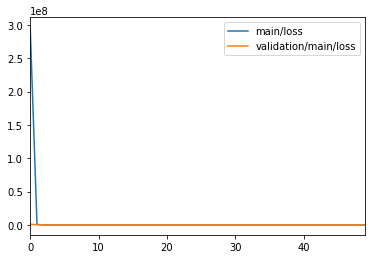

In [64]:
results[['main/loss', 'validation/main/loss']].plot()

### 誤差を元のスケールで確認する。
DataFrameに『.value』する事で、numpyの形式に変換できる。

In [68]:
n_loss_0 = results['validation/main/loss'].values[-1]

元の誤差を計算で求めるためには、ルートを計算する。

In [67]:
import math

In [69]:
math.sqrt(n_loss_0)

9.763992484396121

上記の結果より、誤差は、『9.7％』であることがわかる。

# 更に精度を上げる為に･･･
Optimizerを『Adam』にしてやってみる！！

In [90]:
# 13->5->1
class NN(chainer.Chain):
    # モデルの構造を明示
    def __init__(self, n_mid_units=5, n_out=1):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(None, n_mid_units)  # 入力層
            self.fc2 = L.Linear(None, n_out)  # 出力層

    # 順伝播
    def __call__(self, x):
        h = self.fc1(x)
        h = F.relu(h)
        h = self.fc2(h)
        return h

In [91]:
np.random.seed(0)  # インスタンス化前にシードを固定
nn = NN()  # インスタンス化
model = L.Classifier(nn, lossfun=F.mean_squared_error)  # lossfunを平均二乗誤差を設定する。
model.compute_accuracy = False
optimizer = chainer.optimizers.Adam()  # 確率的勾配降下法
optimizer.setup(model)
batchsize = 10
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)# データに応じてサイズを決定

In [92]:
from chainer import training

In [93]:
updater = training.StandardUpdater(train_iter, optimizer, device=-1)

In [94]:
from chainer.training import extensions

In [95]:
epoch = 50
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result/housing')
trainer.extend(extensions.Evaluator(test_iter, model, device=-1))  # ここでも『device』の設定が必要
trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))  # ログ出力の頻度は１エポックごとに出力
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger=(1, 'epoch'))

In [96]:
trainer._done=False
trainer.run()

epoch       main/loss   validation/main/loss  elapsed_time
1           397.701     334.208               0.0701959     
2           223.402     184.636               0.120794      
3           122.881     132.093               0.172911      
4           97.4672     124.939               0.224281      
5           94.3218     119.44                0.275842      
6           89.3628     114.539               0.332336      
7           85.2529     110.616               0.383755      
8           84.2768     106.384               0.436307      
9           80.0633     102.415               0.487881      
10          77.6488     98.5841               0.539103      
11          75.9718     94.7484               0.59525       
12          72.2957     91.4261               0.647631      
13          70.2987     88.1505               0.701004      
14          69.2722     85.2239               0.753902      
15          68.1619     82.6771               0.805366      
16          65.115      80

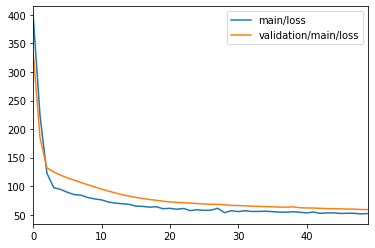

In [97]:
import json

with open('result/housing/log') as f:
    logs = json.load(f)
    results = pd.DataFrame(logs)

results[['main/loss', 'validation/main/loss']].plot()

In [98]:
n_loss_0 = results['validation/main/loss'].values[-1]
import math
math.sqrt(n_loss_0)

7.673187873833176

『Adam』を利用した場合、誤差は『7.673％』になった。

## 更に向上させる為に
今回は『Epoch』を500に変更してみる。

In [99]:
# 13->5->1
class NN(chainer.Chain):
    # モデルの構造を明示
    def __init__(self, n_mid_units=5, n_out=1):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(None, n_mid_units)  # 入力層
            self.fc2 = L.Linear(None, n_out)  # 出力層

    # 順伝播
    def __call__(self, x):
        h = self.fc1(x)
        h = F.relu(h)
        h = self.fc2(h)
        return h

In [100]:
np.random.seed(0)  # インスタンス化前にシードを固定
nn = NN()  # インスタンス化
model = L.Classifier(nn, lossfun=F.mean_squared_error)  # lossfunを平均二乗誤差を設定する。
model.compute_accuracy = False
optimizer = chainer.optimizers.Adam()  # 確率的勾配降下法
optimizer.setup(model)
batchsize = 10
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)# データに応じてサイズを決定

In [101]:
from chainer import training

In [102]:
updater = training.StandardUpdater(train_iter, optimizer, device=-1)

In [103]:
from chainer.training import extensions

In [104]:
epoch = 500
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result/housing')
trainer.extend(extensions.Evaluator(test_iter, model, device=-1))  # ここでも『device』の設定が必要
trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))  # ログ出力の頻度は１エポックごとに出力
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger=(1, 'epoch'))

In [105]:
trainer._done=False
trainer.run()

epoch       main/loss   validation/main/loss  elapsed_time
1           397.701     334.208               0.0871374     
2           223.402     184.636               0.136876      
3           122.881     132.093               0.187942      
4           97.4672     124.939               0.23793       
5           94.3218     119.44                0.288027      
6           89.3628     114.539               0.339237      
7           85.2529     110.616               0.389357      
8           84.2768     106.384               0.440914      
9           80.0633     102.415               0.491811      
10          77.6488     98.5841               0.542693      
11          75.9718     94.7484               0.594601      
12          72.2957     91.4261               0.645284      
13          70.2987     88.1505               0.698146      
14          69.2722     85.2239               0.75017       
15          68.1619     82.6771               0.801163      
16          65.115      80

135         36.1842     39.0913               7.27427       
136         35.9036     38.6582               7.33098       
137         36.3523     38.9251               7.38577       
138         37.2559     38.5722               7.44223       
139         34.1585     38.4288               7.4993        
140         35.5566     38.2789               7.55524       
141         36.3636     38.3949               7.61159       
142         35.2727     38.136                7.66625       
143         34.3577     38.6032               7.72191       
144         36.7468     38.357                7.77742       
145         35.4486     37.9032               7.83353       
146         34.9089     38.0506               7.88995       
147         35.6112     38.0004               7.94485       
148         36.073      38.6087               8.00241       
149         34.2172     37.5495               8.05796       
150         35.1003     37.5142               8.11272       
151         34.9892     

270         32.0652     33.4691               14.9664       
271         31.04       33.3691               15.0247       
272         32.0233     33.7674               15.0823       
273         31.6622     33.3676               15.1408       
274         31.1105     33.5724               15.1985       
275         31.5185     33.5882               15.2563       
276         31.37       34.7119               15.3158       
277         31.8862     33.3937               15.3729       
278         32.1167     33.4854               15.4327       
279         30.5691     33.2148               15.4894       
280         31.4256     33.2637               15.5498       
281         31.1701     33.4429               15.6088       
282         31.7257     33.0303               15.6668       
283         31.469      34.2514               15.7253       
284         31.999      33.193                15.7846       
285         31.3701     34.3793               15.8421       
286         32.2466     

405         30.1581     30.9149               23.0628       
406         29.546      31.8825               23.1295       
407         29.3284     31.1821               23.1892       
408         29.2651     31.157                23.2514       
409         29.2507     30.9058               23.3141       
410         28.7762     31.3779               23.3742       
411         28.6542     31.9026               23.4363       
412         29.7843     31.0416               23.4985       
413         30.2611     31.2818               23.5618       
414         28.2988     31.3266               23.6236       
415         29.7085     31.6529               23.6843       
416         29.9131     31.3831               23.7469       
417         28.526      31.0522               23.8081       
418         29.001      30.8534               23.8703       
419         29.0292     32.1088               23.9311       
420         29.7855     31.7884               23.9918       
421         28.9765     

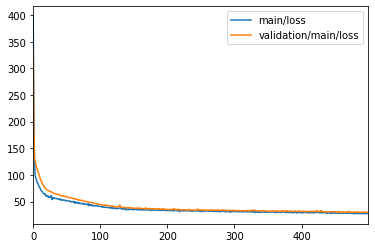

In [106]:
import json

with open('result/housing/log') as f:
    logs = json.load(f)
    results = pd.DataFrame(logs)

results[['main/loss', 'validation/main/loss']].plot()

In [107]:
n_loss_0 = results['validation/main/loss'].values[-1]
import math
math.sqrt(n_loss_0)

5.432143652049421

誤差は、『5.43％』ほどになった

## 更に向上するために
データの中身を確認してみる。

In [108]:
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,y
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


『x1』の値が１より小さい。それぞれの変数のスケールがだいぶ違う。  
こんなデータの場合は → **バッチノーマリゼーション**（**バッチ正規化**）が効きそう  
### バッチノーマリゼーションを追加

In [109]:
# 13->5->1
class NN(chainer.Chain):
    # モデルの構造を明示
    def __init__(self, n_mid_units=5, n_out=1):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(None, n_mid_units)  # 入力層
            self.fc2 = L.Linear(None, n_out)  # 出力層
            # バッチ正規化を追加
            self.bn = L.BatchNormalization(13)

    # 順伝播
    def __call__(self, x):
        h = self.bn(x)
        h = self.fc1(h)
        h = F.relu(h)
        h = self.fc2(h)
        return h

In [110]:
np.random.seed(0)  # インスタンス化前にシードを固定
nn = NN()  # インスタンス化
model = L.Classifier(nn, lossfun=F.mean_squared_error)  # lossfunを平均二乗誤差を設定する。
model.compute_accuracy = False
optimizer = chainer.optimizers.Adam()  # 確率的勾配降下法
optimizer.setup(model)
batchsize = 10
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)# データに応じてサイズを決定

In [111]:
from chainer import training

In [112]:
updater = training.StandardUpdater(train_iter, optimizer, device=-1)

In [113]:
from chainer.training import extensions

In [114]:
epoch = 500
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result/housing')
trainer.extend(extensions.Evaluator(test_iter, model, device=-1))  # ここでも『device』の設定が必要
trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))  # ログ出力の頻度は１エポックごとに出力
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger=(1, 'epoch'))

In [115]:
trainer._done=False
trainer.run()

epoch       main/loss   validation/main/loss  elapsed_time
1           575.005     603.083               0.0800895     
2           558.217     591.554               0.146557      
3           548.793     574.242               0.212882      
4           521.226     547.619               0.277199      
5           504.153     507.164               0.341757      
6           462.463     468.416               0.408125      
7           408.87      413.969               0.474535      
8           366.207     357.926               0.54144       
9           293.685     257.43                0.606406      
10          241.922     227.014               0.671306      
11          192.413     178.442               0.738652      
12          154.55      143.469               0.803575      
13          118.269     114.239               0.870691      
14          99.1176     100.104               0.936391      
15          85.8353     81.4782               1.00229       
16          70.8336     71

135         22.3553     17.6617               9.40223       
136         27.6813     16.8084               9.47566       
137         23.5214     16.664                9.54876       
138         25.1738     17.0243               9.62225       
139         29.423      16.4812               9.69467       
140         26.817      17.3971               9.76764       
141         27.0338     17.1789               9.84113       
142         24.1305     16.5635               9.91327       
143         26.9474     18.0898               9.9871        
144         29.6502     19.9942               10.0604       
145         21.1949     15.7372               10.1324       
146         25.1804     16.4279               10.2064       
147         20.8907     16.9437               10.2797       
148         24.3835     16.4118               10.3544       
149         22.5814     16.5673               10.4267       
150         23.2891     16.7781               10.4984       
151         26.9547     

270         22.9457     13.6819               19.4658       
271         19.064      15.41                 19.5413       
272         21.9487     13.9314               19.6153       
273         19.7314     14.7931               19.689        
274         22.8678     13.7753               19.7609       
275         19.6238     15.1387               19.8344       
276         20.5049     14.7378               19.9087       
277         25.5927     13.989                19.981        
278         24.2375     14.1095               20.0572       
279         19.1778     13.7571               20.1337       
280         24.9742     14.3113               20.2098       
281         21.0122     14.4698               20.2838       
282         23.3627     14.0901               20.3581       
283         20.6962     15.2378               20.4329       
284         22.3905     14.1784               20.5062       
285         23.7292     13.992                20.5804       
286         21.9902     

405         24.1103     13.5065               29.607        
406         19.5203     12.947                29.6833       
407         26.0601     13.327                29.7608       
408         22.3059     12.8057               29.8378       
409         22.5546     13.5309               29.9138       
410         22.858      13.2229               29.9887       
411         21.7052     13.3218               30.0661       
412         23.5897     13.9167               30.1422       
413         24.8847     14.2854               30.2202       
414         20.2391     14.1087               30.2955       
415         19.897      14.38                 30.372        
416         21.4814     13.8151               30.4484       
417         23.5663     13.7989               30.5236       
418         25.611      14.0511               30.6013       
419         21.9081     15.7638               30.6772       
420         22.4531     13.6645               30.757        
421         22.8902     

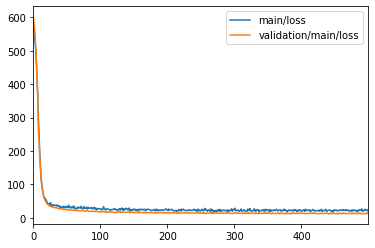

In [116]:
import json

with open('result/housing/log') as f:
    logs = json.load(f)
    results = pd.DataFrame(logs)

results[['main/loss', 'validation/main/loss']].plot()

In [117]:
n_loss_0 = results['validation/main/loss'].values[-1]
import math
math.sqrt(n_loss_0)

3.6647254083897263

誤差は、『3.66％』ほどになった

## 更に向上するために
Adamの中には以下のような引数を設定することもできる。  
  

chainer.optimizers.Adam(  
   - alpha=0.001,  
   - beta1=0.9,  
   - beta2=0.999,  
   - eps=1e-08,  
   - eta=1.0,  
   - weight_decay_rate=0,  
   - amsgrad=False,  
)  
  
データの構造・実行結果を見ながら、より良いモデル構造、設定を見つける事が重要